In [9]:
import numpy as np
import BigFunctions as BF
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import uproot as ur
#%matplotlib tk

In [10]:
#Reading the variables

input_path = "../data/bigdata_CFD_23092024_0001.root"
with ur.open(input_path) as file:
    outTree = file["DataTree"]
    label = outTree["label"].array(library = "np")
    time = outTree["time"].array(library = "np")*10**-6   #[µs]
    nrj = outTree["nrj"].array(library = "np")
    pileup = outTree["pileup"].array(library = "np")

print("Duration of the data acquisition:", max(time)*10**(-6)/3600, "hours")
print("Number of events acquired:", len(label)/10**6, "million")
print("Number of events acquired with PM2:", len(label[label == 2])/10**6, "million")

In [3]:
#To see if there was aproblem during the data acquisition
print(time[label == 1][-50:-1]*10**(-6)/3600)
print(time[label == 2][-50:-1]*10**(-6)/3600)

[29.66090473 29.66090536 29.66090536 29.66090536 29.66090537 29.66090669
 29.66090883 29.66091465 29.66091903 29.6609216  29.66092305 29.66092492
 29.6609276  29.66092876 29.66092876 29.66092974 29.66093033 29.66093167
 29.66093342 29.66093345 29.66093495 29.66093527 29.66093667 29.66093725
 29.66094191 29.66094286 29.66094467 29.66094524 29.66095007 29.66095007
 29.66095113 29.66095269 29.66095607 29.66095697 29.66095794 29.66095846
 29.66096645 29.66096901 29.66096907 29.66096924 29.66096942 29.66096942
 29.66097164 29.66097219 29.66097219 29.66097263 29.66097493 29.66097772
 29.6609808 ]
[29.66091903 29.6609216  29.66092305 29.66092492 29.66092649 29.66092876
 29.66092876 29.66092974 29.66093033 29.66093167 29.6609319  29.66093342
 29.66093345 29.66093495 29.66093527 29.66093535 29.66093667 29.66093894
 29.66094191 29.66094286 29.66094458 29.66094467 29.66094467 29.66094524
 29.66094606 29.66095007 29.66095113 29.66095269 29.66095464 29.66095607
 29.66095697 29.66095794 29.66095846 

In [7]:
#Correlation

corr_t = 10*10**-3   #Correlation window
corr_mask = (time[1:]-time[:-1]<corr_t) & (label[1:] != label[:-1])

correl_both = (np.insert(corr_mask,0,False))|(np.append(corr_mask,False))
del(corr_mask)

t = time[correl_both]
l = label[correl_both]
p = pileup[correl_both]
e = nrj[correl_both]

t1 = time[correl_both & (label==1)]
t2 = time[correl_both & (label==2)]
nrj1 = nrj[correl_both & (label==1)]
nrj2 = nrj[correl_both & (label==2)]

dt2 = t2[1:]-t2[:-1]
dt1 = t1[1:]-t1[:-1]

print("Number of events after correlation:       ", len(t)/10**6, "million")
print("Dead time:                                ", min(dt2), "µs")
print("Total number of pileups:                  ", len(pileup[pileup == True]))
print("Total number of pileups after correlation:", len(p[p == True]))
print("Number of events acquired with PM2 after correlation:", len(l[l == 2])/10**6, "million")

Number of events after correlation:        27.94455 million
Dead time:                                 0.15847015380859375 µs
Total number of pileups:                   0
Total number of pileups after correlation: 0
Number of events acquired with PM2 after correlation: 13.972275 million


... After correlation only ...


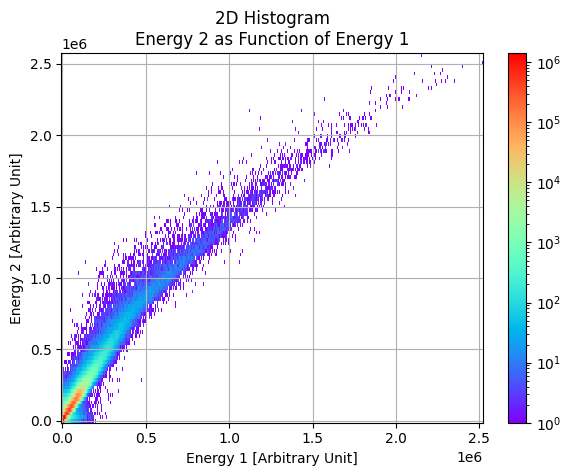

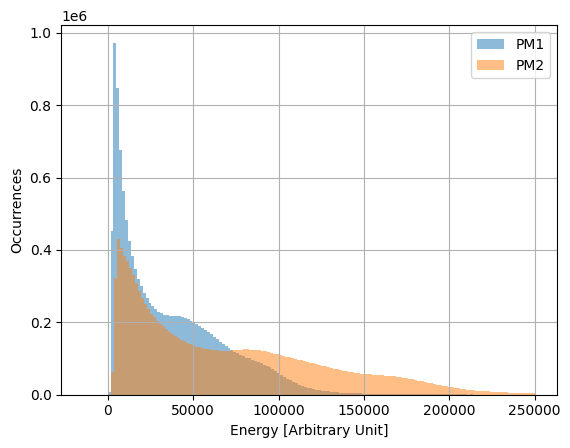

In [8]:
#Energy Analysis

#After correlation only
print('... After correlation only ...')

nrj_max = 250000

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj1, nrj2, bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Energy 1 [Arbitrary Unit]')
ax1.set_ylabel('Energy 2 [Arbitrary Unit]')
ax1.set_title('2D Histogram\nEnergy 2 as Function of Energy 1')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

plt.figure()
plt.hist(nrj1[nrj1 < nrj_max], bins = 150, alpha = 0.5, label = "PM1")
plt.hist(nrj2[nrj2 < nrj_max], bins = 150, alpha = 0.5, label = "PM2")
plt.xlabel("Energy [Arbitrary Unit]")
plt.ylabel("Occurrences")
plt.grid()
plt.legend()
plt.show()

... After correlation and cut on dt ...
Number of events acquired with PM2 after correlation and cut on dt: 0.180677 million


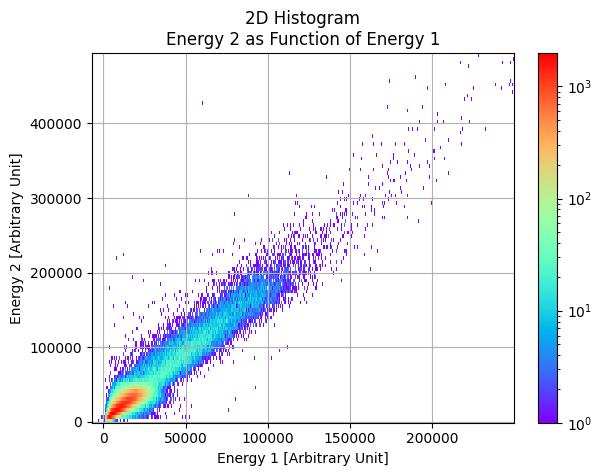

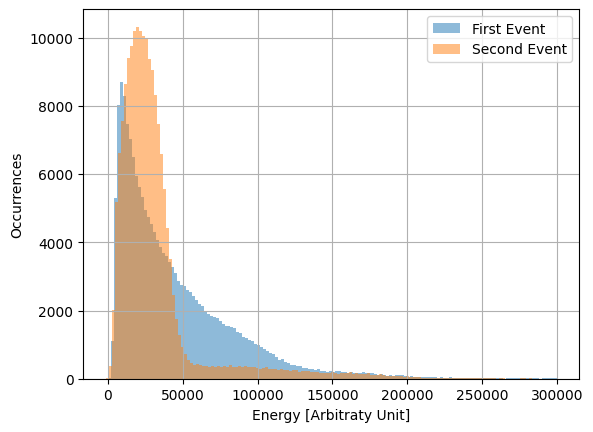

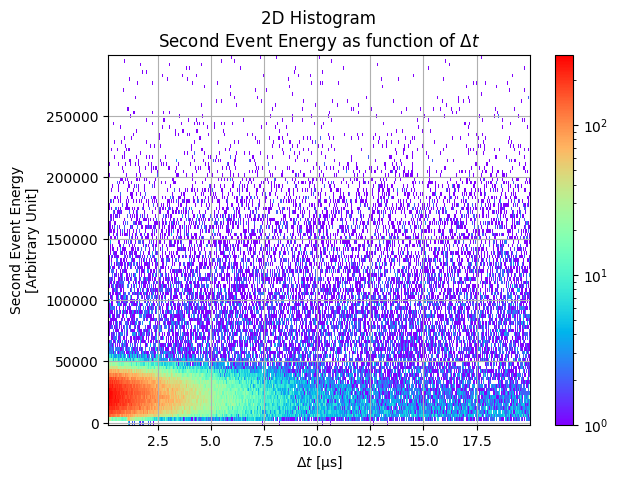

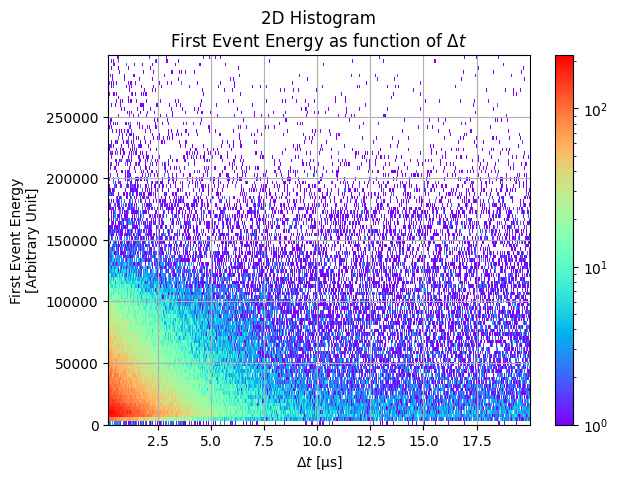

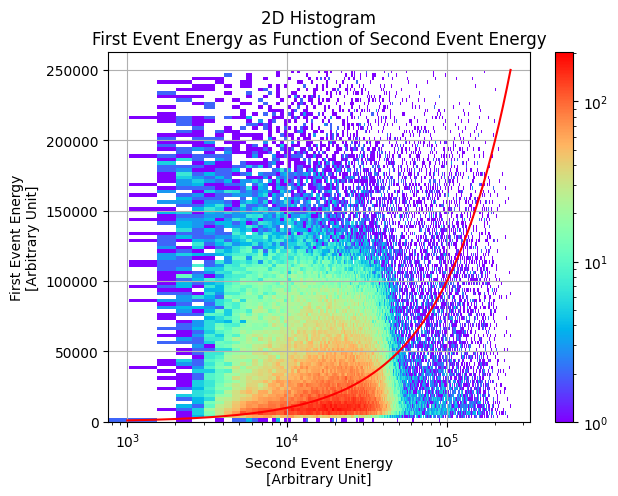

In [11]:
#After correlation and cut on dt
print('... After correlation and cut on dt ...')

dt_max = 20
print("Number of events acquired with PM2 after correlation and cut on dt:", len(dt2[dt2 < 20])/10**6, "million")

#Energy PM1 vs energy PM2
fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj1[1:][(dt2 < dt_max)&(nrj1[1:]<0.25e6)&(nrj2[1:]<0.5e6)], 
                                 nrj2[1:][(dt2 < dt_max)&(nrj1[1:]<0.25e6)&(nrj2[1:]<0.5e6)], 
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Energy 1 [Arbitrary Unit]')
ax1.set_ylabel('Energy 2 [Arbitrary Unit]')
ax1.set_title('2D Histogram\nEnergy 2 as Function of Energy 1')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

#Muon and electron energy
plt.figure()
#plt.hist(nrj2[1:][(nrj2[1:]<nrj_max) & (dt2<dt_max)], bins=150, label="Second Event", alpha = 0.5)
#plt.hist(nrj2[:-1][(nrj2[:-1]<nrj_max)  & (dt2<dt_max)], bins=150, label="First Event", alpha = 0.5)
plt.hist(nrj2[(nrj2<nrj_max) & (np.append(dt2, np.nan)<dt_max)], bins=150, label="First Event", alpha = 0.5)
plt.hist(nrj2[(nrj2<nrj_max) & (np.insert(dt2, 0, np.nan)<dt_max)], bins=150, label="Second Event", alpha = 0.5)
plt.xlabel('Energy [Arbitraty Unit]')
plt.ylabel('Occurrences')
plt.legend()
plt.grid()
plt.show()

#Electron as function of dt
fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(dt2[(nrj2[1:]<nrj_max) & (dt2<dt_max)], 
                                 nrj2[1:][(nrj2[1:]<nrj_max) & (dt2<dt_max)],
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('$\Delta t$ [µs]')
ax1.set_ylabel('Second Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nSecond Event Energy as function of $\Delta t$')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

#Muon as function of dt
fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(dt2[(nrj2[:-1]<nrj_max) & (dt2<dt_max)], 
                                 nrj2[:-1][(nrj2[:-1]<nrj_max) & (dt2<dt_max)],
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('$\Delta t$ [µs]')
ax1.set_ylabel('First Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nFirst Event Energy as function of $\Delta t$')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

#Muon as function of electron

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)],
                                 nrj2[:-1][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)],  
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Second Event Energy\n[Arbitrary Unit]')
ax1.set_ylabel('First Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nFirst Event Energy as Function of Second Event Energy')
ax1.grid()
ax1.plot(np.linspace(1000, 250000, 10000),np.linspace(1000,250000, 10000),c='r')
ax1.set_xscale("log")
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

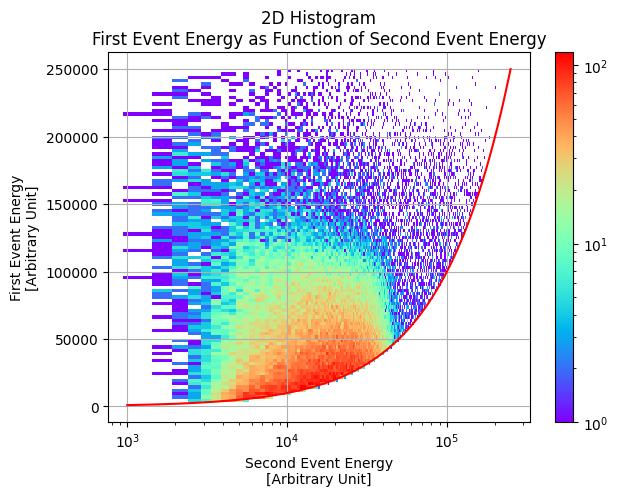

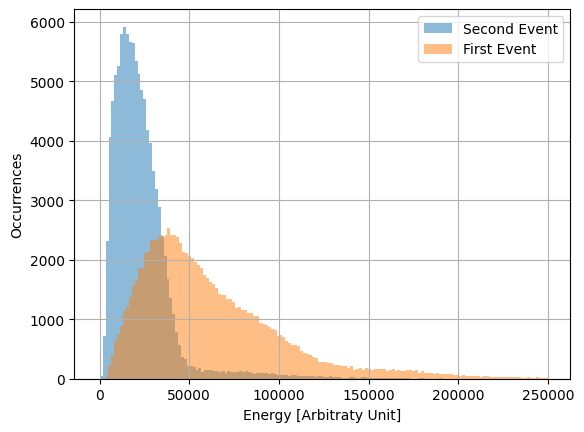

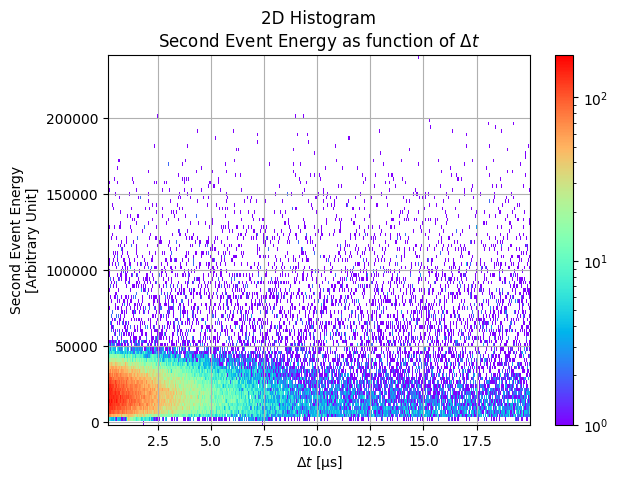

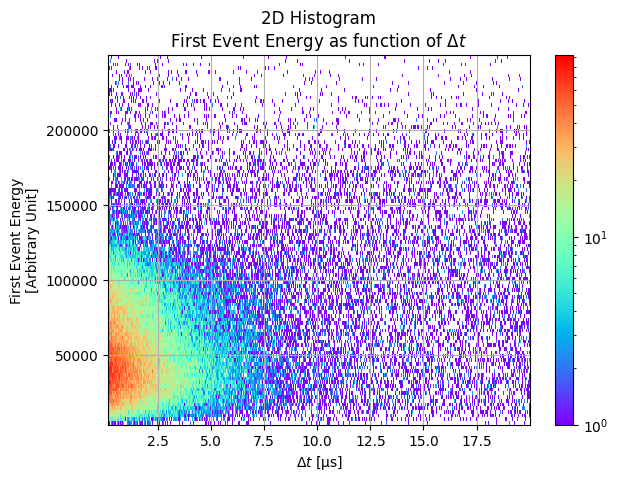

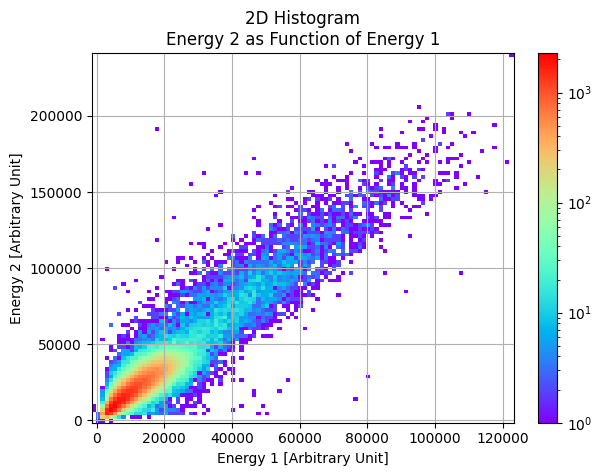

In [12]:
#After correlation, cut on dt and cut on electron/muon energy

mask = nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)] < nrj2[:-1][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)]

#Muon as function of electron

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask],
                                 nrj2[:-1][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask],  
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Second Event Energy\n[Arbitrary Unit]')
ax1.set_ylabel('First Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nFirst Event Energy as Function of Second Event Energy')
ax1.grid()
ax1.plot(np.linspace(1000, 250000, 10000),np.linspace(1000,250000, 10000),c='r')
ax1.set_xscale("log")
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

#Muon and electron energy
plt.figure()
plt.hist(nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask], bins=150, label="Second Event", alpha = 0.5)
plt.hist(nrj2[:-1][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask], bins=150, label="First Event", alpha = 0.5)
#plt.hist(nrj2[(nrj2<nrj_max) & (np.append(dt2, np.nan)<dt_max)], bins=150, label="First Event", alpha = 0.5)
#plt.hist(nrj2[(nrj2<nrj_max) & (np.insert(dt2, 0, np.nan)<dt_max)], bins=150, label="Second Event", alpha = 0.5)
plt.xlabel('Energy [Arbitraty Unit]')
plt.ylabel('Occurrences')
plt.legend()
plt.grid()
plt.show()

#Electron as function of dt
fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask], 
                                 nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask],
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('$\Delta t$ [µs]')
ax1.set_ylabel('Second Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nSecond Event Energy as function of $\Delta t$')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

#Muon as function of dt
fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask], 
                                 nrj2[:-1][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask],
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('$\Delta t$ [µs]')
ax1.set_ylabel('First Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nFirst Event Energy as function of $\Delta t$')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

#Energy PM1 vs energy PM2

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj1[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask], 
                                 nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask], 
                                 bins =(100,100))

pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Energy 1 [Arbitrary Unit]')
ax1.set_ylabel('Energy 2 [Arbitrary Unit]')
ax1.set_title('2D Histogram\nEnergy 2 as Function of Energy 1')
ax1.grid()
#ax1.plot([0,120000], [0, 1.8*120000], c='k')
#ax1.plot([0,120000], [0+beta, (alpha*120000)+beta], c='k', alpha = 0.5)
#ax1.plot([0,120000], [0-beta, (alpha*120000)-beta], c='k', alpha = 0.5)
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

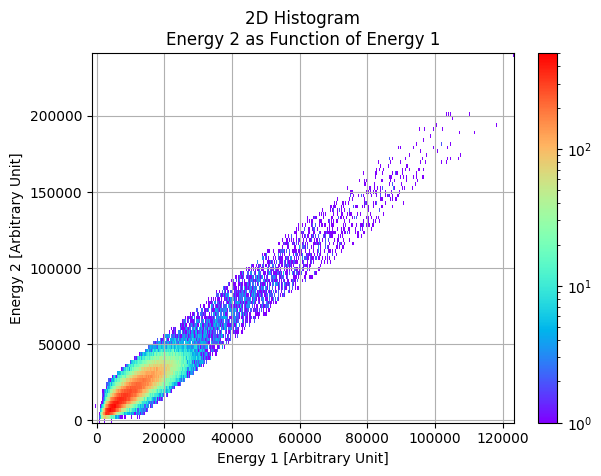

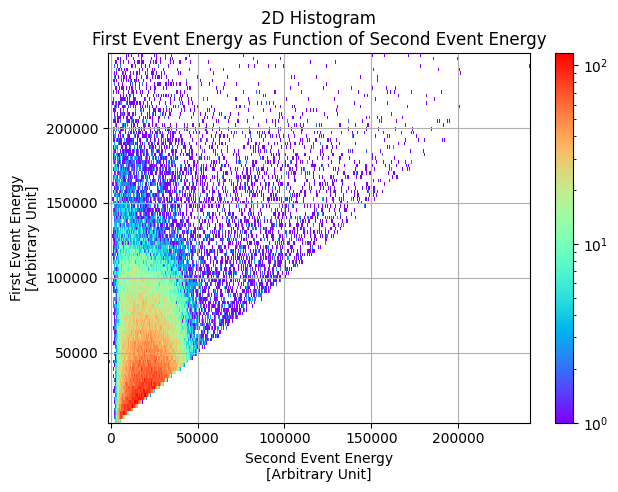

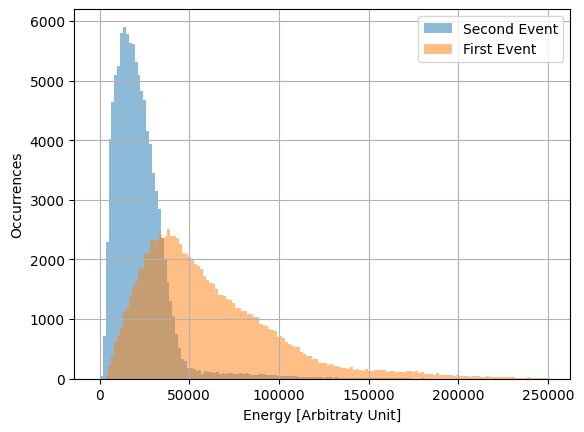

In [13]:
#Correlation, cut on dt, Eµ>Ee and linearity

#Energy PM1 vs energy PM2

alpha = 1.8
beta = 20000

mask2 = (alpha*nrj1[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask]+beta>=nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask])&(alpha*nrj1[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask]-beta<=nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask])

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj1[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask][mask2], 
                                 nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask][mask2], 
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Energy 1 [Arbitrary Unit]')
ax1.set_ylabel('Energy 2 [Arbitrary Unit]')
ax1.set_title('2D Histogram\nEnergy 2 as Function of Energy 1')
ax1.grid()
#ax1.plot([0,120000], [0, 1.8*120000], c='k')
#ax1.plot([0,120000], [0+beta, (alpha*120000)+beta], c='k', alpha = 0.5)
#ax1.plot([0,120000], [0-beta, (alpha*120000)-beta], c='k', alpha = 0.5)
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

#Muon as function of electron

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask][mask2],
                                 nrj2[:-1][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask][mask2],  
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Second Event Energy\n[Arbitrary Unit]')
ax1.set_ylabel('First Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nFirst Event Energy as Function of Second Event Energy')
ax1.grid()
#ax1.plot(np.linspace(1000, 250000, 10000),np.linspace(1000,250000, 10000),c='r')
#ax1.set_xscale("log")
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()


#Muon and electron energy

plt.figure()
plt.hist(nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask][mask2], bins=150, label="Second Event", alpha = 0.5)
plt.hist(nrj2[:-1][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask][mask2], bins=150, label="First Event", alpha = 0.5)
#plt.hist(nrj2[(nrj2<nrj_max) & (np.append(dt2, np.nan)<dt_max)], bins=150, label="First Event", alpha = 0.5)
#plt.hist(nrj2[(nrj2<nrj_max) & (np.insert(dt2, 0, np.nan)<dt_max)], bins=150, label="Second Event", alpha = 0.5)
plt.xlabel('Energy [Arbitraty Unit]')
plt.ylabel('Occurrences')
plt.legend()
plt.grid()
plt.show()

/home/hind/Documents/Cours/Cours M2/TL/BigMuoneXperiment/BigFunctions.py:5: RuntimeWarning: overflow encountered in exp
  def exp2(t, N0, lam1, lam2, C) : return N0*np.exp(-lam1*t) + 1.15*N0*np.exp(-lam2*t) + C
/home/hind/Documents/Cours/Cours M2/TL/BigMuoneXperiment/BigFunctions.py:5: RuntimeWarning: overflow encountered in multiply
  def exp2(t, N0, lam1, lam2, C) : return N0*np.exp(-lam1*t) + 1.15*N0*np.exp(-lam2*t) + C


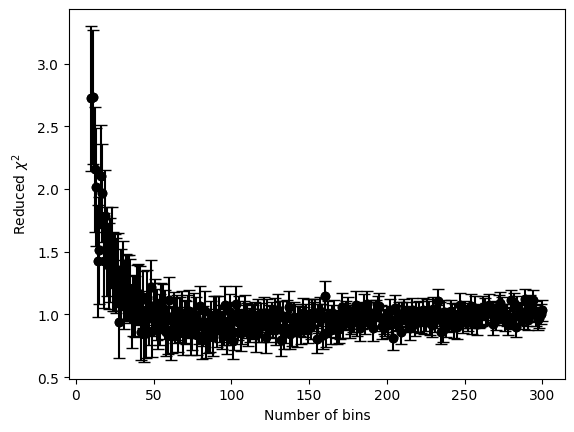

1.0000245592780126
Closest chi2 to 1: [] +/- []
Corresponding number of bins []


In [14]:
#Bins optimisation

dt_max = 20
dt = dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask]

plt.figure()
N_bins = np.array(range(10,301))
chi2_lst = []
chi2_err_lst = []

for n in N_bins :
    hist = np.histogram(dt, bins = n)
    x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
    y = hist[0]
    y_err = np.sqrt(y)

    popt, cov = curve_fit(BF.exp2, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 2, 400]))
    N0 = popt[0]
    lam1 = popt[1]
    lam2 = popt[2]
    CC = popt[3]

    chi2 = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[0]
    chi2_err = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[1]

    chi2_lst.append(chi2)
    chi2_err_lst.append(chi2_err)

    plt.errorbar(n, chi2, yerr = chi2_err, linestyle = 'None', fmt='o', capsize=4, c='k')
    plt.scatter(n, chi2, c='k')

plt.xlabel("Number of bins")
plt.ylabel("Reduced $\chi^2$")
plt.show()

chi2_lst = np.array(chi2_lst)
chi2_err_lst = np.array(chi2_err_lst)
print(min(np.abs(1-chi2_lst))+1)

print("Closest chi2 to 1:", chi2_lst[np.argwhere(chi2_lst == min(np.abs(1-chi2_lst))+1)], "+/-", chi2_err_lst[np.argwhere(chi2_lst == min(np.abs(1-chi2_lst))+1)])
print("Corresponding number of bins", N_bins[np.argwhere(chi2_lst == min(np.abs(1-chi2_lst))+1)]) 

Number of events acquired with PM2 after correlation cut on dt and energies: 0.104601 million
... Fit with one exponential ...
chi2 =  0.9822623842535646 +/- 0.10721125348377948


... Fit with two exponentials ...
chi2 =  0.9539941189087937 +/- 0.10752066611409407


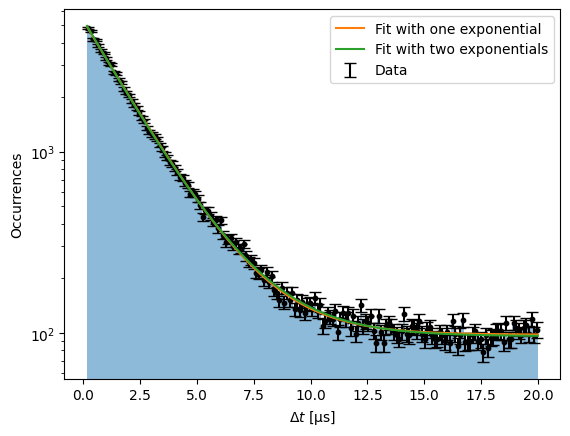

tau1 =          1.6899413513254975 +/- 0.074608811214441 [µs]
tau2 =          2.2642140689999035 +/- 0.0428150249859956 [µs]


In [17]:
import warnings
warnings.filterwarnings('ignore')
#dt Analysis 

dt_max = 20
dt = dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask]
print("Number of events acquired with PM2 after correlation cut on dt and energies:", len(dt)/10**6, "million")

N_bins = 177
hist = np.histogram(dt, bins = N_bins)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)

#Fit----------------------------------------------------

#With one exponential
popt, cov = curve_fit(BF.exp1, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 400]))
N01 = popt[0]
lam = popt[1]
C = popt[2]
lam_err = cov[1,1]

chi2 = BF.chi2_norm(y, BF.exp1(x, N01, lam, C), y_err, 3)[0]
chi2_err = BF.chi2_norm(y, BF.exp1(x, N01, lam, C), y_err, 3)[1]
print("... Fit with one exponential ...")
print("chi2 = ", chi2, '+/-', chi2_err)
print('\n')

#With two exponentials
popt, cov = curve_fit(BF.exp2, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 2, 400]))
N0 = popt[0]
lam1 = popt[1]
lam1_err = np.sqrt(cov[1,1])
lam2 = popt[2]
lam2_err = np.sqrt(cov[2,2])
CC = popt[3]

chi2 = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[0]
chi2_err = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[1]
print("... Fit with two exponentials ...")
print("chi2 = ", chi2, '+/-', chi2_err)

#-------------------------------------------------------

plt.figure()
plt.hist(dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask], bins = N_bins, alpha = 0.5)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='-', capsize=4, c='k', label = 'Data')
plt.scatter(x, y, c='k', s=10)
plt.plot(np.linspace(min(dt), max(dt), 100), BF.exp1(np.linspace(min(dt), max(dt), 100), N01, lam, C), 
                     label = 'Fit with one exponential')
plt.plot(np.linspace(min(dt), max(dt), 100), BF.exp2(np.linspace(min(dt), max(dt), 100), N0, lam1, lam2, CC), 
                     label = 'Fit with two exponentials')
plt.xlabel("$\Delta t$ [µs]")
plt.ylabel("Occurrences")
plt.yscale('log')
plt.legend()
plt.show()

tau1 = 1/lam1
tau1_err = lam1_err/lam1**2
tau2 = 1/lam2
tau2_err = lam2_err/lam2**2

print('tau1 =         ', tau1, '+/-', tau1_err, '[µs]')
print('tau2 =         ', tau2, '+/-', tau2_err, '[µs]')

Number of events acquired with PM2 after correlation cut on dt and energies: 0.178922 million
... Fit with two exponentials ...
chi2 =  1.0427377293385227 +/- 0.10783277320343841


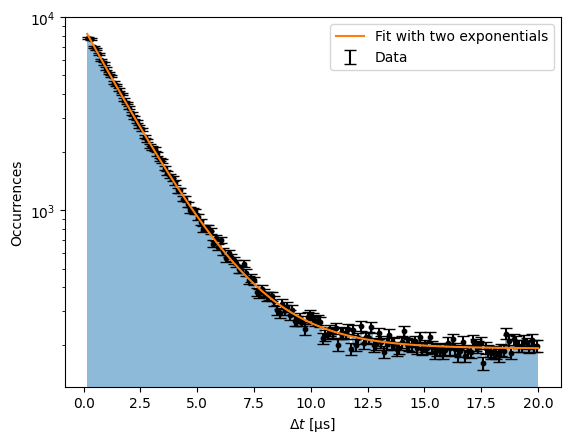

tau1 =          2.1976940055022425 +/- 0.42069622305846754 [µs]
tau2 =          1.6304266216653287 +/- 0.8782588095033638 [µs]
Reduced chi2:   1.0427377293385227 +/- 0.10783277320343841


In [14]:
#dt Analysis 

dt_max = 20
dt = dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)]
print("Number of events acquired with PM2 after correlation cut on dt and energies:", len(dt)/10**6, "million")

N_bins = 177
hist = np.histogram(dt, bins = N_bins)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)

#Fit----------------------------------------------------

#With two exponentials
popt, cov = curve_fit(BF.exp4, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 20000, 2, 2, 400]))
N01 = popt[0]
N02 = popt[1]
lam1 = popt[2]
lam2 = popt[3]
C = popt[4]
lam1_err = np.sqrt(cov[2,2])
lam2_err = np.sqrt(cov[3,3])

chi2 = BF.chi2_norm(y, BF.exp4(x, N01, N02, lam1, lam2, C), y_err, 5)[0]
chi2_err = BF.chi2_norm(y, BF.exp4(x, N01, N02, lam1, lam2, C), y_err, 5)[1]
print("... Fit with two exponentials ...")
print("chi2 = ", chi2, '+/-', chi2_err)

#-------------------------------------------------------

plt.figure()
plt.hist(dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)], bins = N_bins, alpha = 0.5)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='-', capsize=4, c='k', label = 'Data')
plt.scatter(x, y, c='k', s=10)
plt.plot(np.linspace(min(dt), max(dt), 100), BF.exp4(np.linspace(min(dt), max(dt), 100), N01, N02, lam1, lam2, C), 
                     label = 'Fit with two exponentials')
plt.xlabel("$\Delta t$ [µs]")
plt.ylabel("Occurrences")
plt.yscale('log')
plt.legend()
plt.show()

tau1 = 1/lam1
tau1_err = lam1_err/lam1**2
tau2 = 1/lam2
tau2_err = lam2_err/lam2**2

print('tau1 =         ', tau1, '+/-', tau1_err, '[µs]')
print('tau2 =         ', tau2, '+/-', tau2_err, '[µs]')
print('Reduced chi2:  ', chi2, '+/-', chi2_err)

In [21]:
#dt Analysis 

dt_max = np.array([5, 10, 15, 20])
dt = dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask]
print("Number of events acquired with PM2 after correlation cut on dt and energies:", len(dt)/10**6, "million")

N_bins = 150
hist = np.histogram(dt, bins = N_bins)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)

#Fit----------------------------------------------------

#With two exponentials
popt, cov = curve_fit(BF.exp2, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 2, 400]))
N0 = popt[0]
lam1 = popt[1]
lam1_err = np.sqrt(cov[1,1])
lam2 = popt[2]
lam2_err = np.sqrt(cov[2,2])
CC = popt[3]

chi2 = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[0]
chi2_err = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[1]
print("... Fit with two exponentials ...")
print("chi2 = ", chi2, '+/-', chi2_err)



Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/hind/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_209217/731034273.py", line 4, in <module>
    dt = dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask]
ValueError: operands could not be broadcast together with shapes (11148349,) (4,) 

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hind/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/hind/.local/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/hind/.local/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
    return VerboseTB.stru

In [22]:
tau = 1/lam
tau_err = lam_err/lam**2

tau1 = 1/lam1
tau1_err = lam1_err/lam1**2

tau2 = 1/lam2
tau2_err = lam2_err/lam2**2

print("... Fit with one exponential ...")
print('tau = ', tau, '+/-', tau_err, 'µs')
print('\n')
print('... Fit with two exponentials ...')
print('tau1 = ', tau1, '+/-', tau1_err, 'µs')
print('tau2 = ', tau2, '+/-', tau2_err, 'µs')

... Fit with one exponential ...
tau =  2.023804371924896 +/- 2.9470339632968485e-05 µs


... Fit with two exponentials ...
tau1 =  1.6142233129161003 +/- 0.07253490670675761 µs
tau2 =  2.282644057161969 +/- 0.03940863562417091 µs


... Fit with one exponential ...
chi2 =  1.1402428512628409 +/- 0.21821789023599236


... Fit with two exponentials ...
chi2 =  1.0648136814293978 +/- 0.2208630521496931


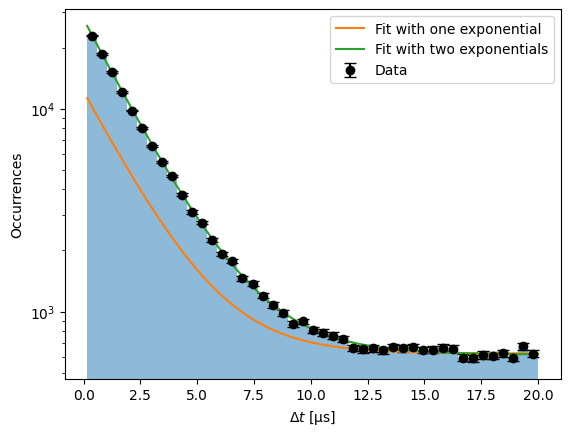

In [58]:
#dt Analysis 

dt_max = 20
dt = dt2[dt2 < dt_max]

N_bins = 45
hist = np.histogram(dt, bins = N_bins)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)

#Fit----------------------------------------------------

#With one exponential
popt, cov = curve_fit(BF.exp1, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 400]))
N0 = popt[0]
lam = popt[1]
C = popt[2]
lam_err = cov[1,1]

chi2 = BF.chi2_norm(y, BF.exp1(x, N0, lam, C), y_err, 3)[0]
chi2_err = BF.chi2_norm(y, BF.exp1(x, N0, lam, C), y_err, 3)[1]
print("... Fit with one exponential ...")
print("chi2 = ", chi2, '+/-', chi2_err)
print('\n')

#With two exponentials
popt, cov = curve_fit(BF.exp2, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 2, 400]))
N0 = popt[0]
lam1 = popt[1]
lam1_err = np.sqrt(cov[1,1])
lam2 = popt[2]
lam2_err = np.sqrt(cov[2,2])
CC = popt[3]
CC_err = np.sqrt(cov[3,3])

chi2 = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[0]
chi2_err = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[1]
print("... Fit with two exponentials ...")
print("chi2 = ", chi2, '+/-', chi2_err)

#-------------------------------------------------------

plt.figure()
plt.hist(dt2[dt2 < dt_max], bins = N_bins, alpha = 0.5)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='o', capsize=4, c='k', label = 'Data')
plt.plot(np.linspace(min(dt), max(dt), 100), BF.exp1(np.linspace(min(dt), max(dt), 100), N0, lam, C), 
                     label = 'Fit with one exponential')
plt.plot(np.linspace(min(dt), max(dt), 100), BF.exp2(np.linspace(min(dt), max(dt), 100), N0, lam1, lam2, CC), 
                     label = 'Fit with two exponentials')
plt.xlabel("$\Delta t$ [µs]")
plt.ylabel("Occurrences")
plt.yscale('log')
plt.legend()
plt.show()

In [59]:
tau = 1/lam
tau_err = lam_err/lam**2

tau1 = 1/lam1
tau1_err = lam1_err/lam1**2

tau2 = 1/lam2
tau2_err = lam2_err/lam2**2

print("... Fit with one exponential ...")
print('tau = ', tau, '+/-', tau_err, 'µs')
print('\n')
print('... Fit with two exponentials ...')
print('tau1 = ', tau1, '+/-', tau1_err, 'µs')
print('tau2 = ', tau2, '+/-', tau2_err, 'µs')
print("C =", CC, '+/-', CC_err)

... Fit with one exponential ...
tau =  2.032800984498693 +/- 1.882290381447346e-05 µs


... Fit with two exponentials ...
tau1 =  2.3120490744600186 +/- 0.06527404263784593 µs
tau2 =  1.804325308957612 +/- 0.05861568391566418 µs
C = 613.4749564252669 +/- 6.800197384234117


... Fit with two exponentials ...
chi2 =  1.0464257592043424 +/- 0.10752066611409407
0.4932758779833086 17.404873170885406


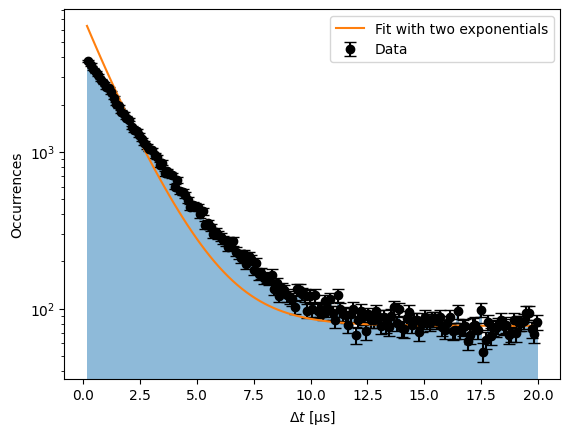

In [21]:
#With lam and lam_c

dt_max = 20
dt = dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask]

N_bins = 177
hist = np.histogram(dt, bins = N_bins)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)

popt, cov = curve_fit(BF.exp3, x, y, sigma=y_err, absolute_sigma = True, p0=np.array([20000, 2, 1, 600]))
N0 = popt[0]
lam = popt[1]
lam_err = np.sqrt(cov[1,1])
lam_c = popt[2]
lam_c_err = np.sqrt(cov[2,2])
CC = popt[3]
CC_err = np.sqrt(cov[3,3])

chi2 = BF.chi2_norm(y, BF.exp3(x, N0, lam, lam_c, CC), y_err, 4)[0]
chi2_err = BF.chi2_norm(y, BF.exp3(x, N0, lam, lam_c, CC), y_err, 4)[1]
print("... Fit with two exponentials ...")
print("chi2 = ", chi2, '+/-', chi2_err)

print(lam, lam_c)

plt.figure()
plt.hist(dt, bins = N_bins, alpha = 0.5)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='o', capsize=4, c='k', label = 'Data')
plt.plot(np.linspace(min(dt), max(dt), 100), BF.exp3(np.linspace(min(dt), max(dt), 100), N0, lam1, lam2, CC), 
                     label = 'Fit with two exponentials')
plt.xlabel("$\Delta t$ [µs]")
plt.ylabel("Occurrences")
plt.yscale('log')
plt.legend()
plt.show()

In [19]:
from pylab import *
from scipy import odr

dt_max = 20
dt = dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)]

def func(p, x):
    N01, N02, lam1, lam2, C = p
    return N01*np.exp(-lam1*t) + N02*np.exp(-lam2*t) + C

# Model object
exp_model = odr.Model(func)

hist = np.histogram(dt, bins = N_bins)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
x_err = len(x)*[0.003]
y_err = np.sqrt(y)

# Create a RealData object
data = odr.RealData(x, y, sx=x_err, sy=y_err)

# Set up ODR with the model and data.
odr = odr.ODR(data, exp_model, beta0=[20000, 20000, 2, 2, 400])

# Run the regression.
out = odr.run()

#print fit parameters and 1-sigma estimates
popt = out.beta
perr = out.sd_beta
print("fit parameter 1-sigma error")
print("———————————–")
for i in range(len(popt)):
    print(str(popt[i])+" +/- "+str(perr[i]))

# prepare confidence level curves
nstd = 5. # to draw 5-sigma intervals
popt_up = popt + nstd * perr
popt_dw = popt - nstd * perr

x_fit = np.linspace(min(x), max(x), 100)
fit = func(popt, x_fit)
fit_up = func(popt_up, x_fit)
fit_dw= func(popt_dw, x_fit)

#plot
fig, ax = plt.subplots(1)
rcParams["font.size"]= 20
errorbar(x, y, yerr=y_err, xerr=x_err, hold=True, ecolor='k', fmt='none', label='data')
xlabel('$\Delta t$', fontsize=18)
ylabel('Occurrences', fontsize=18)
title('fit with error on both axis', fontsize=18)
plot(x_fit, fit, 'r', lw=2, label='best fit curve')
plot(x, y, 'k–', lw=2, label='True curve')
ax.fill_between(x_fit, fit_up, fit_dw, alpha=.25, label='5-sigma interval')
legend(loc='lower right',fontsize=18)
show()

(27944550,)
[(1, 177), (177,)]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/hind/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_269170/1934434252.py", line 24, in <module>
    odr = odr.ODR(data, exp_model, beta0=[20000, 20000, 2, 2, 400])
  File "/home/hind/.local/lib/python3.10/site-packages/scipy/odr/_odrpack.py", line 784, in __init__
    self._check()
  File "/home/hind/.local/lib/python3.10/site-packages/scipy/odr/_odrpack.py", line 850, in _check
    raise OdrError("fcn does not output %s-shaped array" % y_s)
scipy.odr._odrpack.OdrError: fcn does not output [177]-shaped array

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hind/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/hind/.local/lib/python3.1